# Example of model selection using cross-validation with RecTools

- CV split
- Training a variety of models
- Measuring a variety of metrics

In [ ]:
from pprint import pprint

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

from implicit.nearest_neighbours import TFIDFRecommender, BM25Recommender
from implicit.als import AlternatingLeastSquares

from rectools import Columns
from rectools.dataset import Interactions, Dataset
from rectools.metrics import Precision, Recall, MeanInvUserFreq, Serendipity, calc_metrics
from rectools.models import ImplicitItemKNNWrapperModel, RandomModel, PopularModel
from rectools.model_selection import TimeRangeSplitter

## Load data

In [2]:
# !wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip ml-1m.zip

import urllib.request
import zipfile as zf

urllib.request.urlretrieve('https://files.grouplens.org/datasets/movielens/ml-1m.zip', 'ml-1m.zip')
files = zf.ZipFile('ml-1m.zip','r')
files.extractall()
files.close()

In [3]:
%%time
ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    engine="python",  # Because of 2-chars separators
    header=None,
    names=[Columns.User, Columns.Item, Columns.Weight, Columns.Datetime],
)
print(ratings.shape)
ratings.head()

(1000209, 4)
CPU times: total: 5.19 s
Wall time: 5.19 s


,user_id,item_id,weight,datetime
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
ratings["user_id"].nunique(), ratings["item_id"].nunique()

(6040, 3706)

In [5]:
ratings["weight"].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: weight, dtype: int64

In [6]:
ratings["datetime"] = pd.to_datetime(ratings["datetime"] * 10 ** 9)
print("Time period")
ratings["datetime"].min(), ratings["datetime"].max()

Time period


(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

Optimize dataframe for further usage. `Interactions` will cast types and save new `pd.DataFrame` inside in `Interactions.df`

In [7]:
inters = Interactions(ratings)
del ratings
inters.df.head()

,user_id,item_id,weight,datetime
0,1,1193,5.0,2000-12-31 22:12:40
1,1,661,3.0,2000-12-31 22:35:09
2,1,914,3.0,2000-12-31 22:32:48
3,1,3408,4.0,2000-12-31 22:04:35
4,1,2355,5.0,2001-01-06 23:38:11


## Split interactions for CV

We'll use last 3 periods of 2 weeks to validate our models.

In [8]:
n_folds = 3
unit = "W"
n_units = 2

last_date = inters.df[Columns.Datetime].max().normalize()
start_date=last_date - pd.Timedelta(n_folds * n_units + 1, unit=unit)  # Start date of first test fold
periods=n_folds + 1
freq=f"{n_units}{unit}"
print(
    f"start_date: {start_date}\n"
    f"last_date: {last_date}\n"
    f"periods: {periods}\n"
    f"freq: {freq}\n"
)

date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)
print(f"Test fold borders: {date_range.values.astype('datetime64[D]')}")

# Init generator of folds
cv = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)
print(f"Real number of folds: {cv.get_n_splits(inters)}")

start_date: 2003-01-10 00:00:00
last_date: 2003-02-28 00:00:00
periods: 4
freq: 2W

Test fold borders: ['2003-01-12' '2003-01-26' '2003-02-09' '2003-02-23']
Real number of folds: 3


## Train models

In [9]:
# Take few simple models to compare
models = {
    "random": RandomModel(),
    "popular": PopularModel(),
    "most_raited": PopularModel(popularity="sum_weight"),
    "tfidf_k=5": ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=5)),
    "tfidf_k=10": ImplicitItemKNNWrapperModel(model=TFIDFRecommender(K=10)),
    "bm25_k=10_k1=0.05_b=0.1": ImplicitItemKNNWrapperModel(model=BM25Recommender(K=5, K1=0.05, B=0.1)),
}

# We will calculate several classic (precision@k and recall@k) and "beyond accuracy" metrics
metrics = {
    "prec@1": Precision(k=1),
    "prec@10": Precision(k=10),
    "recall": Recall(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10),
}

K_RECOS = 10

In [10]:
# For each fold generate train and test part of dataset
# Then fit every model, generate recommendations and calculate metrics

results = []

fold_iterator = cv.split(inters, collect_fold_stats=True)
n_splits = cv.get_n_splits(inters)

for i_fold, (train_ids, test_ids, fold_info) in tqdm(enumerate(fold_iterator), total=n_splits):
    print(f"\n==================== Fold {i_fold}")
    pprint(fold_info)

    df_train = inters.df.iloc[train_ids]
    dataset = Dataset.construct(df_train)

    df_test = inters.df.iloc[test_ids][Columns.UserItem]
    test_users = np.unique(df_test[Columns.User])

    # Catalog is set of items that we recommend.
    # Sometimes we recommend not all items from train.
    catalog = df_train[Columns.Item].unique()

    for model_name, model in models.items():
        model.fit(dataset)
        recos = model.recommend(
            users=test_users,
            dataset=dataset,
            k=K_RECOS,
            filter_viewed=True,
        )
        metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train,
            catalog=catalog,
        )
        res = {"fold": i_fold, "model": model_name}
        res.update(metric_values)
        results.append(res)

  0%|          | 0/3 [00:00<?, ?it/s]


==================== Fold 0
{'End date': Timestamp('2003-01-26 00:00:00', freq='2W-SUN'),
 'Start date': Timestamp('2003-01-12 00:00:00', freq='2W-SUN'),
 'Test': 419,
 'Test items': 339,
 'Test users': 78,
 'Train': 997837,
 'Train items': 3706,
 'Train users': 6040}

==================== Fold 1
{'End date': Timestamp('2003-02-09 00:00:00', freq='2W-SUN'),
 'Start date': Timestamp('2003-01-26 00:00:00', freq='2W-SUN'),
 'Test': 1105,
 'Test items': 817,
 'Test users': 71,
 'Train': 998256,
 'Train items': 3706,
 'Train users': 6040}

==================== Fold 2
{'End date': Timestamp('2003-02-23 00:00:00', freq='2W-SUN'),
 'Start date': Timestamp('2003-02-09 00:00:00', freq='2W-SUN'),
 'Test': 535,
 'Test items': 443,
 'Test users': 68,
 'Train': 999361,
 'Train items': 3706,
 'Train users': 6040}


In [11]:
# Aggregate metrics by folds and compare models
pivot_results = pd.DataFrame(results).drop(columns="fold").groupby(["model"], sort=False).agg(["mean", "std"])
pivot_results.round(5)

prec@1           prec@10            recall           \
                            mean      std     mean      std     mean      std   
model                                                                           
random                   0.00000  0.00000  0.00324  0.00455  0.00105  0.00091   
popular                  0.04224  0.01659  0.03695  0.01355  0.03498  0.00764   
most_raited              0.03734  0.01017  0.03691  0.01450  0.02871  0.00691   
tfidf_k=5                0.05121  0.01111  0.03477  0.01460  0.02991  0.01059   
tfidf_k=10               0.03306  0.01756  0.03580  0.01633  0.02912  0.01059   
bm25_k=10_k1=0.05_b=0.1  0.04756  0.03129  0.03964  0.01330  0.04094  0.00231   

                         novelty          serendipity           
                            mean      std        mean      std  
model                                                           
random                   6.41292  0.11337     0.00033  0.00034  
popular                  1.59682  0.05620     0.00020  0.00009  
most_raited              1.60840  0.05644     0.00017  0.00005  
tfidf_k=5                2.34470  0.05885     0.00120  0.00057  
tfidf_k=10               2.15511  0.06599     0.00079  0.00048  
bm25_k=10_k1=0.05_b=0.1  1.80611  0.09575     0.00033  0.00000

In [12]:
final_results = pivot_results.sort_values(by=[('recall', 'mean'), ('serendipity', 'mean')], ascending=False)
final_results

prec@1             prec@10              recall  \
                             mean       std      mean       std      mean   
model                                                                       
bm25_k=10_k1=0.05_b=0.1  0.047563  0.031291  0.039643  0.013302  0.040941   
popular                  0.042239  0.016591  0.036953  0.013549  0.034979   
tfidf_k=5                0.051208  0.011108  0.034773  0.014600  0.029908   
tfidf_k=10               0.033064  0.017556  0.035795  0.016333  0.029116   
most_raited              0.037337  0.010172  0.036911  0.014500  0.028706   
random                   0.000000  0.000000  0.003244  0.004554  0.001049   

                                    novelty           serendipity            
                              std      mean       std        mean       std  
model                                                                        
bm25_k=10_k1=0.05_b=0.1  0.002308  1.806109  0.095750    0.000331  0.000005  
popular                  0.007638  1.596825  0.056199    0.000204  0.000089  
tfidf_k=5                0.010592  2.344700  0.058846    0.001201  0.000567  
tfidf_k=10               0.010594  2.155112  0.065987    0.000787  0.000478  
most_raited              0.006912  1.608399  0.056444    0.000171  0.000049  
random                   0.000909  6.412918  0.113372    0.000333  0.000342

In [ ]:
subset = [(metric, agg) for metric, agg in final_results.columns if agg == 'mean']
(final_results.style
    .highlight_min(subset=subset, color='red', axis=0)
    .highlight_max(subset=subset, color='lightgreen', axis=0))

Output

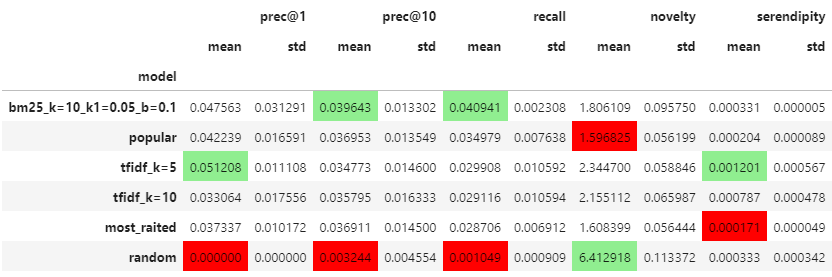